In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel("Incidents.xlsx")
df["ttr_days"]=df["am_ttr"]/3600/24
df.drop(columns=["am_ttr"], inplace=True)
df.drop(columns=["global_ttr_seconds"], inplace=True)

In [3]:
df = df[df["ttr_days"]<df["ttr_days"].quantile(0.90)]

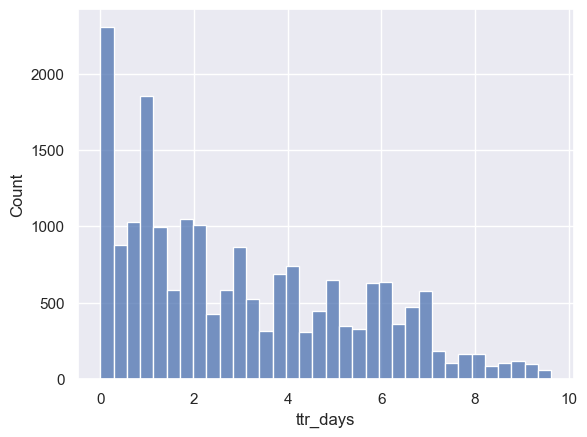

In [4]:
sns.set(style="darkgrid")
sns.histplot(data=df,x="ttr_days")
plt.show()

In [ ]:
# df = df[df["global_ttr_seconds"]>60*3]
# df["ttr_log"] = np.log10(df["global_ttr_seconds"])
# sns.histplot(data=df,x="ttr_log")
# plt.show()

In [22]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    - y: total seconds to resolve an incident ticket
    - X: subset of field
    '''
    # Predict ttr_log = seconds from ticket creation until resolution (log transformed)
    y = df['ttr_days']

    X = df.drop(columns=[
    "reassignment_count","inc_ka_flag","ttr_days", "sla_stage","breached_reason_code","dv_u_zcode","csat_score",
    "prod_appl_name","appl_environment","kcs_solution",
    "primary_product_line","dv_u_coe","parent_bs_sub_product_line", "plme","dv_u_region","caller_requester_region","label",
    "cluster","rgn_nm","assignment_group", "assignment_group_company"
    ], axis=1)
  
    # Fill numeric columns with the mean (limited to csat_score)
    num_vars = X.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        X[col].fillna((df[col].mean()), inplace=True)
    
    # Dummy the categorical variables
    cat_vars = X.select_dtypes(include=['object']).copy().columns

    X = X.apply(lambda x: x.mask(x.map(x.value_counts())<20, 'other') if x.name in cat_vars else x)
    
    for var in  cat_vars:
        X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)

    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    

In [23]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.21013172599844476.  The rsquared on the test data was 0.20597679306260097.


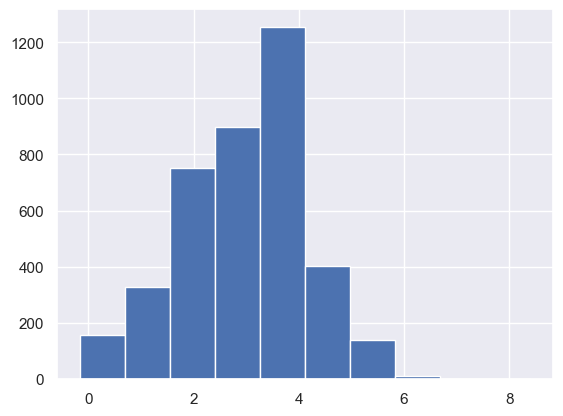

In [8]:
plt.hist(y_test_preds)
plt.show()


In [24]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.to_excel("IncidentDuration_coef.xlsx")